In [17]:
import torch
import sys
import os
import pandas as pd
from scipy import misc
from torchvision import transforms
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import numpy as np
import imageio
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score, roc_curve

from model import *
from AliLoader import *

In [18]:
LS = 2 #Latent Space Size
batch_size = 12
ColorsNumber = 1

#Encoder param
EncKernel = [5,4,4,4,4,1,1]
EncStride = [1,2,1,2,1,1,1]
EncDepth = [32,64,128,256,512,512,LS]

#Generator param
GenKernel = [4,4,4,4,5,1,1]
GenStride = [1,2,1,2,1,1,1]
GenDepth = [256,128,64,32,32,32,ColorsNumber]

#Discriminator X param
DxKernel = [5,4,4,4,4]
DxStride = [1,2,1,2,1]
DxDepth = [32,64,128,256,512]

#Discriminator Z param
DzKernel = [1,1]
DzStride = [1,1]
DzDepth = [512,512]

#Concat Discriminator param
DxzKernel = [1,1,1]
DxzStride = [1,1,1]
DxzDepth = [1024,1024,1]



In [19]:
datadir = "./images/"


In [20]:
# Transformations
inputsize = [224, 224]
inputsize = [32,32]
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(inputsize),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize dataloader
dataset = XrayDataset(datadir, transform=data_transforms)
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

ConstantImg = DataLoader(dataset, shuffle=False, batch_size=9)

print(len(dataset))

501


torch.Size([1, 1, 32, 32])


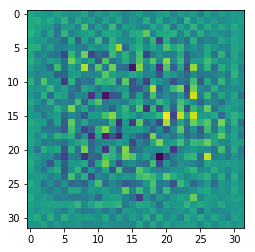

In [21]:


    
    
GenX = Generator(latent_size=LS,KS=GenKernel,ST=GenStride,DP=GenDepth)
fkim = GenX(torch.rand(1,LS,1,1))
print(fkim.shape)
plt.imshow(fkim.detach().numpy()[0][0])
plt.show()

In [22]:
class Maxout(nn.Module):
    def __init__(self, pool_size):
        super().__init__()
        self._pool_size = pool_size

    def forward(self, x):
        assert x.shape[-1] % self._pool_size == 0, \
            'Wrong input last dim size ({}) for Maxout({})'.format(x.shape[-1], self._pool_size)
        m, i = x.view(*x.shape[:-1], x.shape[-1] // self._pool_size, self._pool_size).max(-1)
        return m

In [23]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)


In [24]:
import torch.optim as optim




DisX = DiscriminatorX(KS=DxKernel,ST=DxStride,DP=DxDepth)
DisZ = DiscriminatorZ(KS=DzKernel,ST=DzStride,DP=DzDepth,LS=LS)
DisXZ = DiscriminatorXZ(KS=DxzKernel,ST=DxzStride,DP=DxzDepth)

GenZ = Encoder(KS=EncKernel,ST=EncStride,DP=EncDepth,LS=LS)
GenX = Generator(latent_size=LS,KS=GenKernel,ST=GenStride,DP=GenDepth)

    


In [25]:
for dataiter in ConstantImg:
    #Get Data
    data = dataiter
    data_norm = data*2.0-1.0
    break

In [26]:


lr = 1e-4
b1 = 0.5
b2 = 1e-3
optimizerG = optim.Adam([{'params' : GenX.parameters()},
                         {'params' : GenZ.parameters()}], lr=lr, betas=(b1,b2))

optimizerD = optim.Adam([{'params' : DisZ.parameters()},{'params': DisX.parameters()},
                         {'params' : DisXZ.parameters()}], lr=lr, betas=(b1,b2))

DiscriminatorLoss = []


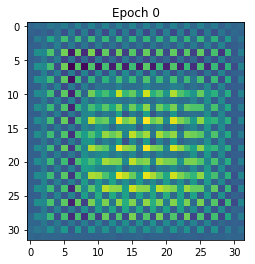

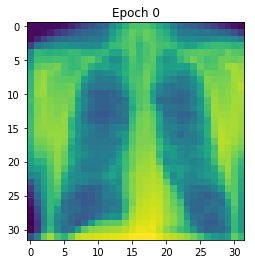

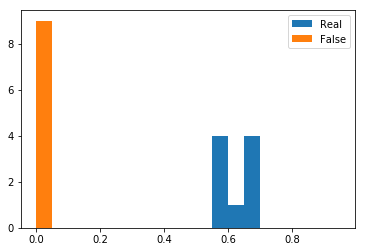

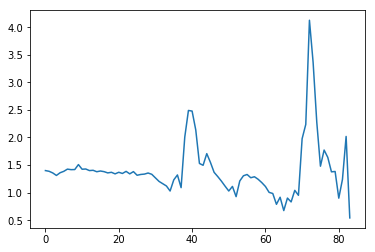

In [58]:
from torch.autograd import Variable


ConstantZ = torch.randn(9,LS,1,1)

cpt = 0

criterion = nn.BCELoss()
for epoch in range(2):
    
    #Store Discriminator data
    AllRealDisc = []
    AllFakeDisc = []
    
    
    c = 0
    for dataiter in dataloader:
        c += 1
        
        #Get Data
        Xnorm = dataiter *2.0 - 1.0
        #print(c,Xnorm.shape)
        #To cuda
        if torch.cuda.is_available():
            Xnorm = Xnorm.cuda()
        
        #Get Batch Size
        BS = Xnorm.shape[0]
        if BS < batch_size/2.0:
            continue
        
        #Generate Fake data from random Latent
        FakeZ = torch.randn(BS,LS,1,1)
        FakeX = GenX(FakeZ)
        
        #Generate Latent from Real
        RealZ = GenZ(Xnorm)
        
        #Have discriminator do is thing on real and fake data
        RealCat= torch.cat((DisZ(RealZ), DisX(Xnorm)), 1)
        FakeCat= torch.cat((DisZ(FakeZ), DisX(FakeX)), 1)
        PredReal  = DisXZ(RealCat)
        PredFalse = DisXZ(FakeCat)
        
        #Get loss for discriminator
        loss_d = criterion(PredReal.view(-1), Variable(torch.ones(BS)-0.1)) + criterion(PredFalse.view(-1), Variable(torch.zeros(BS)))

        #Get loss for generator
        loss_g = criterion(PredFalse.view(-1), Variable(torch.ones(BS)-0.1)) + criterion(PredReal.view(-1), Variable(torch.zeros(BS)))

        #Optimize Discriminator
        
        optimizerD.zero_grad()
        loss_d.backward(retain_graph=True)
        optimizerD.step()
    
        #Optimize Generator
        
        optimizerG.zero_grad()
        loss_g.backward()
        optimizerG.step()
    
    
        #StoreInfo
        DiscriminatorLoss.append(loss_d.detach().numpy()+0)
        AllRealDisc = list(np.ravel(PredReal.detach().numpy()))
        AllFakeDisc = list(np.ravel(PredFalse.detach().numpy()))
        
        
        
    if epoch % 1 == 0:
        with torch.no_grad():
            FakeData = GenX(ConstantZ).detach().numpy()
            plt.imshow(FakeData[0][0])
            plt.title("Epoch %d" % (epoch))
            plt.show()

            plt.imshow(data[0][0])
            plt.title("Epoch %d" % (epoch))
            plt.show()


            #print("Epoch:%d AUC:%.2f" % (epoch,auc))

            plt.hist(AllRealDisc,bins=np.array(range(20))/20,label="Real")
            plt.hist(AllFakeDisc,np.array(range(20))/20,label="False")
            plt.legend()
            plt.show()


            plt.plot(range(len(DiscriminatorLoss)),DiscriminatorLoss)
            plt.show()
    break


In [59]:
with torch.no_grad():
    FakeData = GenX(ConstantZ)

    PredFalse = DisXZ(torch.cat((DisZ(ConstantZ), DisX(FakeData)), 1))


    FakeData = FakeData.detach().numpy()
    PredFalse= PredFalse.detach().numpy()

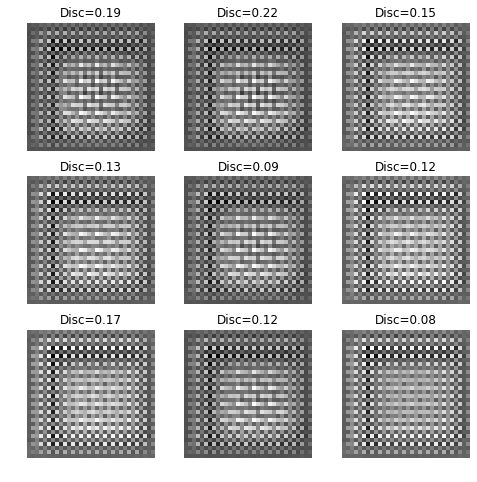

In [60]:

plt.figure(figsize=(8,8))

c = 0
for i in range(9):
    c +=1
    #print(fd.shape)
    plt.subplot(3,3,c)
    plt.imshow(FakeData[i][0],cmap="gray")
    plt.title("Disc=%.2f" % (PredFalse[i]))
    plt.axis("off")
plt.show()

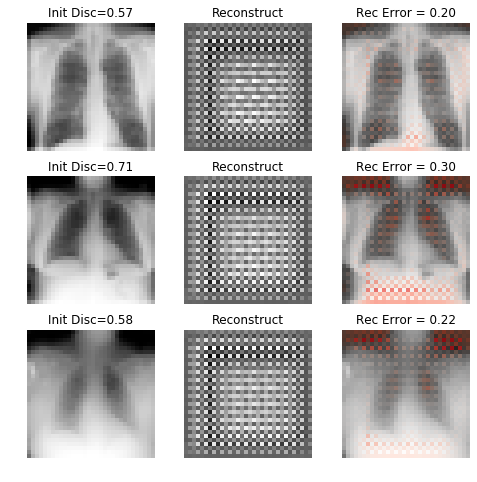

In [61]:
from matplotlib.colors import ListedColormap

# Get the colormap colors
cmap = plt.cm.Reds
AlphaRed = cmap(np.arange(cmap.N))
# Set alpha
AlphaRed[:,-1] = np.linspace(0, 1, cmap.N)
# Create new colormap
AlphaRed = ListedColormap(AlphaRed)

for dataiter in ConstantImg:
    #Get Data
    data = dataiter
    Xnorm = data*2.0-1.0
    break
with torch.no_grad():
    #Generate Latent from Real
    RealZ = GenZ(Xnorm)
    RebuildX = GenX(RealZ)
    DiffX = Xnorm - RebuildX
    DiffX = DiffX.detach().numpy()
    DiffX = np.power(DiffX,2)
    RebuildX = RebuildX.detach().numpy()
    #Have discriminator do is thing on real and fake data
    PredReal  = DisXZ(torch.cat((DisZ(RealZ), DisX(Xnorm)), 1)).detach().numpy()

plt.figure(figsize=(8,8))
c = 0
Sample = 3
for i in range(Sample):
    c+= 1
    plt.subplot(Sample,3,c)
    plt.imshow(Xnorm[i][0],cmap="gray")
    plt.title("Init Disc=%.2f" % (PredReal[i]))
    plt.axis("off")
    c+= 1
    plt.subplot(Sample,3,c)
    plt.imshow(RebuildX[i][0],cmap="gray")
    plt.title("Reconstruct")
    plt.axis("off")
    c+= 1
    plt.subplot(Sample,3,c)
    plt.imshow(Xnorm[i][0],cmap="gray")
    plt.title("Rec Error = %.2f" % (np.mean(DiffX[i][0])))
    plt.imshow(DiffX[i][0],cmap=AlphaRed,vmin=0,vmax=2)
    plt.axis("off")
    
    
    
plt.savefig("./test.png")


In [63]:
Xnorm.shape

torch.Size([9, 1, 32, 32])

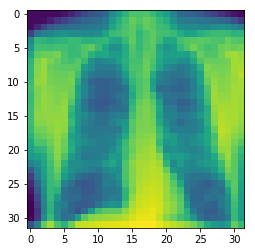

torch.Size([9, 1, 32, 32])


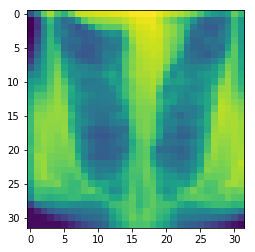

In [93]:
plt.imshow(Xnorm.detach().numpy()[0][0])
plt.show()
XFlip = np.copy(Xnorm.detach().numpy())
XFlip = XFlip[:,:,range(32)[::-1],:]

XFlip = torch.tensor(XFlip)
print(XFlip.shape)
plt.imshow(XFlip.detach().numpy()[0][0])
plt.show()

In [100]:
Z = RealZ.detach().numpy()
Z.resize((RealZ.shape[:2]))
print(np.sum(np.power(Z,2),axis=1))

[ 9.738616   3.0503058  3.1043825  3.877304  33.893875  13.078027
 19.700851  17.959112   6.8159328]


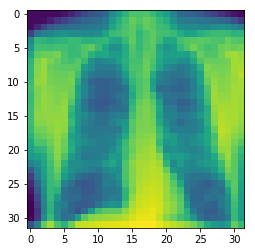

(9, 1024)
[ 0.07612595  0.01800707 -0.06292892 -0.09979318 -0.13335627 -0.00814183
  0.05072764  0.05958182 -0.12208945]
[ 0.07612595  0.01800707 -0.0629289  -0.09979318 -0.13335629 -0.00814183
  0.05072765  0.05958182 -0.12208945]
(9, 1024)


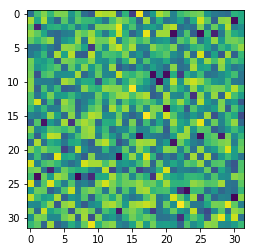

In [82]:
plt.imshow(Xnorm.detach().numpy()[0][0])
plt.show()

XnormShuffle = np.copy(Xnorm.reshape(9,32*32).detach().numpy())
print(XnormShuffle.shape)
print(np.mean(XnormShuffle,axis=1))
np.random.shuffle(XnormShuffle.transpose())
print(np.mean(XnormShuffle,axis=1))
print(XnormShuffle.shape)
XnormShuffle = torch.tensor(XnormShuffle)

XnormShuffle = XnormShuffle.reshape(9,1,32,32)
plt.imshow(XnormShuffle.detach().numpy()[0][0])
plt.show()

array([-0.32549018, -0.00392157,  0.69411767, ...,  0.0196079 ,
        0.24705887, -0.18431371], dtype=float32)

In [16]:
import torchvision.datasets as dset

In [ ]:
transforms.ToPILImage(),
    transforms.Resize(inputsize),
    transforms.ToTensor(),

In [58]:
Xnorm.shape

torch.Size([9, 1, 32, 32])

In [59]:
#Load MNIST
#MNIST

transform = transforms.Compose([
                    transforms.Resize([32,32]),
                    transforms.ToTensor()])

MNIST_set = dset.MNIST(root="./model/default/", train=True, transform=transform, download=True)
MNIST_loader = torch.utils.data.DataLoader(dataset=MNIST_set,batch_size=9,shuffle=False)

for mnist,lab in MNIST_loader:
    print(mnist.shape)
    break

torch.Size([9, 1, 32, 32])


In [38]:
FakeData.shape

(9, 1, 32, 32)

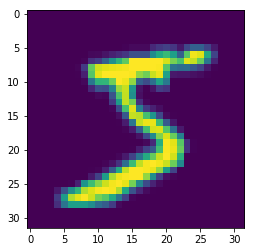

In [57]:
plt.imshow(mnist[0][0].detach().numpy())

In [15]:
from sklearn import manifold
Xr = RealZ.detach().numpy()
Xr.resize((Xr.shape[:2]))


Xf = ConstantZ.detach().numpy()
Xf.resize((Xf.shape[:2]))

X = np.concatenate((Xf,Xr))

tsne = manifold.TSNE(n_components=2, init='random',
                     random_state=0, perplexity=5)
Y = tsne.fit_transform(X)

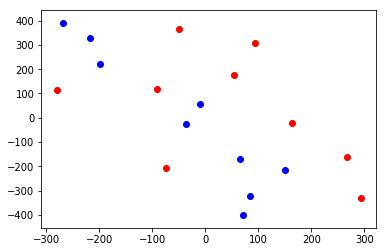

In [16]:
plt.scatter(Y[:Xr.shape[0],0],Y[:Xr.shape[0],1],c="red")
plt.scatter(Y[Xr.shape[0]:,0],Y[Xr.shape[0]:,1],c="blue")

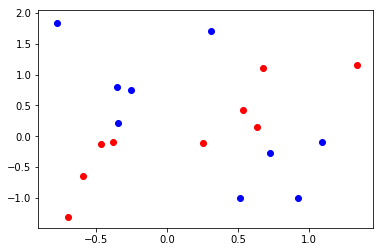

In [17]:
plt.scatter(Xr[:,0],Xr[:,1],c="red")
plt.scatter(Xf[:,0],Xf[:,1],c="blue")

In [143]:
class OtherXrayDataset(Dataset):

    def __init__(self, datadir, transform=None, nrows=-1):

        self.datadir = datadir
        self.transform = transform
        print(datadir+"/*/*/*.png")
        self.ImgFiles = [f.split(datadir)[-1] for f in glob.glob(datadir+"/*/*/*/*.png")]
        if nrows > 0:
            self.ImgFiles = self.ImgFiles[:nrows]

    def __len__(self):
        return len(self.ImgFiles)

    def __getitem__(self, idx):
        #print(idx)
        #print(self.datadir)
        print(self.ImgFiles[idx])
        im = misc.imread(os.path.join(self.datadir, self.ImgFiles[idx]))
        if len(im.shape) > 2:
            im = im[:, :, 0]
        #Add color chanel
        im = im[:,:,None]
        # Tranform
        if self.transform:
            im = self.transform(im)
        return im

In [144]:
OtherXRay = OtherXrayDataset("./OtherXray/", transform=data_transforms,nrows=10)

./OtherXray//*/*/*.png


In [145]:
OtherXRay = OtherXrayDataset("./OtherXray/", transform=data_transforms)
otherxray = DataLoader(OtherXRay, shuffle=False, batch_size=batch_size)

./OtherXray//*/*/*.png
